In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/instant-gratification/sample_submission.csv
/kaggle/input/instant-gratification/train.csv
/kaggle/input/instant-gratification/test.csv


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
train = pd.read_csv("/kaggle/input/instant-gratification/train.csv")
test = pd.read_csv("/kaggle/input/instant-gratification/test.csv")
submission = pd.read_csv("/kaggle/input/instant-gratification/sample_submission.csv")

In [5]:
print(f'train: {train.shape}, test: {test.shape}')

train: (262144, 258), test: (131072, 257)


In [6]:
print(f"정답 비율:\n {train['target'].value_counts()}")

정답 비율:
 1    131131
0    131013
Name: target, dtype: int64


정답누출 확인


<Axes: >

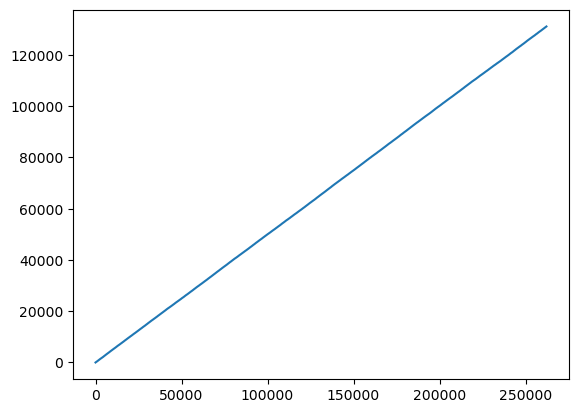

In [7]:
print("정답누출 확인")
train['target'].cumsum().plot()

In [8]:
print(f"전체 데이터 중 NULL 개수: {train.isnull().sum().sum()}")

전체 데이터 중 NULL 개수: 0


In [9]:
print("데이터 유형 살펴보기")
train.dtypes.value_counts()   #train.info()

데이터 유형 살펴보기


float64    255
int64        2
object       1
dtype: int64

In [10]:
train.select_dtypes(include=['object', 'int64']).head()

,id,wheezy-copper-turtle-magic,target
0,707b395ecdcbb4dc2eabea00e4d1b179,99,0
1,5880c03c6582a7b42248668e56b4bdec,52,0
2,4ccbcb3d13e5072ff1d9c61afe2c4f77,230,1
3,e350f17a357f12a1941f0837afb7eb8d,78,0
4,a8f910ea6075b6376af079055965ff68,497,0


In [11]:
train_columns = [c for c in train.columns if c not in ('id', 'target')]
train[train_columns].nunique().sort_values()

wheezy-copper-turtle-magic               512
lanky-coral-moorhen-expert            253919
shaggy-silver-indri-fimbus            253956
baggy-copper-oriole-dummy             253989
wheezy-harlequin-earwig-gaussian      254004
                                       ...  
squeaky-khaki-lionfish-distraction    254815
snoopy-heliotrope-squid-dataset       254824
hazy-tan-schnauzer-hint               254947
chewy-bistre-buzzard-expert           254991
skinny-ultramarine-cat-fimbus         255057
Length: 256, dtype: int64

In [12]:
#개수를 세고 index에 이름을 붙여주고 index를 열로 넣으면서 다른 열에도 이름을 붙인다. (Series의 rest_index는 df의 그것과 좀 다른 듯)
train['wheezy-copper-turtle-magic'].value_counts().rename_axis(index='wheezy-copper-turtle-magic').reset_index(name='counts')

,wheezy-copper-turtle-magic,counts
0,51,570
1,489,556
2,298,554
3,135,554
4,245,553
...,...,...
507,277,476
508,215,475
509,108,472
510,42,471


In [13]:
train_columns = [c for c in train.columns if c not in ('id', 'target', 'wheezy-copper-turtle-magic')]

describe_train = train[train_columns].describe().drop("count", axis=0).T
cmap = sns.diverging_palette(5, 250, as_cmap=True)
describe_train.T.style.background_gradient(cmap, axis=1).set_precision(2)

/tmp/ipykernel_32/2048058468.py:5: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  describe_train.T.style.background_gradient(cmap, axis=1).set_precision(2)


<Figure size 1600x1200 with 0 Axes>

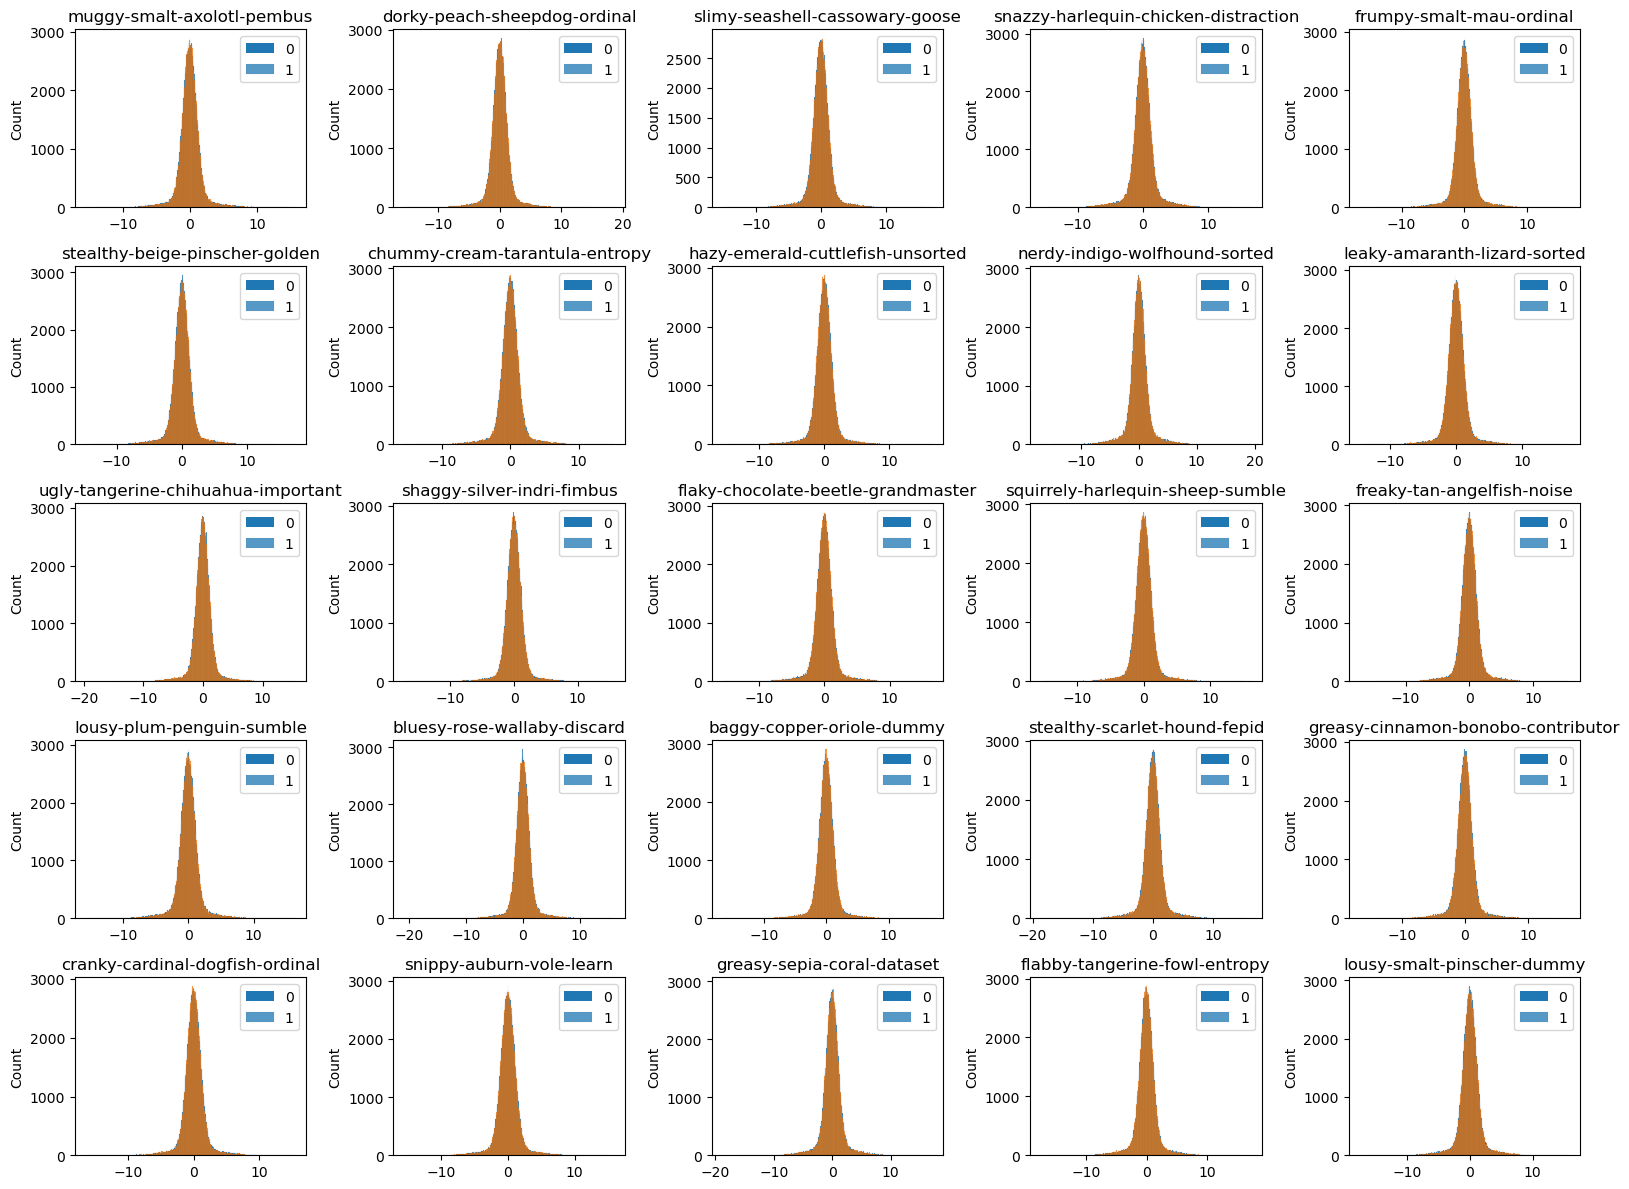

In [14]:
train_columns = [c for c in train.columns if c not in ('id', 'target')]
target_0_df = train.loc[train['target'] == 0]
target_1_df = train.loc[train['target'] == 1]

plt.figure(figsize=(16,12))
f, axes = plt.subplots(5,5,figsize=(16,12))
for i, name in enumerate(train_columns[:25]):
    ax = axes[i//5, i%5]
    sns.histplot(target_0_df[name], ax=ax)
    sns.histplot(target_1_df[name], ax=ax)    
    ax.title.set_text(name)
    ax.set_xlabel("")
    ax.legend(["0", "1"])
    
plt.tight_layout()
plt.show()

# 모델 만들기

In [15]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedKFold

from sklearn.decomposition import KernelPCA
from sklearn.mixture import GaussianMixture as GMM
from sklearn import svm, neighbors, linear_model, neural_network
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import lightgbm as lgbm
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [16]:
class hist_model(object):
    
    def __init__(self, bins=50):
        self.bins = bins
        
    def fit(self, X):
        
        bin_hight, bin_edge = [], []
        
        for var in X.T:
            # get bins hight and interval
            bh, bedge = np.histogram(var, bins=self.bins)
            bin_hight.append(bh)
            bin_edge.append(bedge)
        
        self.bin_hight = np.array(bin_hight)
        self.bin_edge = np.array(bin_edge)

    def predict(self, X):
        
        scores = []
        for obs in X:
            obs_score = []
            for i, var in enumerate(obs):
                # find wich bin obs is in
                bin_num = (var > self.bin_edge[i]).argmin()-1
                obs_score.append(self.bin_hight[i, bin_num]) # find bin hitght
            
            scores.append(np.mean(obs_score))
        
        return np.array(scores)

In [17]:
def run_model(clf_list, train, test, random_state, gmm_init_params='kmeans'):
    MODEL_COUNT = len(clf_list)
    
    oof_train = np.zeros((len(train), MODEL_COUNT))
    oof_test = np.zeros((len(test), MODEL_COUNT))    
    train_columns = [c for c in train.columns if c not in ('id', 'target', 'wheezy-copper-turtle-magic')]

    for magic in tqdm(range(512)):
        x_train = train[train['wheezy-copper-turtle-magic'] == magic]
        x_test = test[test['wheezy-copper-turtle-magic'] == magic]
        
#         print('Magic / train_shape / test_shape: ', magic, x_train.shape, x_test.shape)
        
        train_idx_origin = x_train.index
        test_idx_origin = x_test.index
        
        train_std = x_train[train_columns].std()
        useful_cols = train_std[train_std > 2].index
        
        y_train = x_train.target
        x_train = x_train.reset_index(drop=True)
        y_train = x_train.target
        x_train = x_train[useful_cols]
        x_test = x_test.reset_index(drop=True)[useful_cols]

        all_data = pd.concat([x_train, x_test])
        
        
        #Kernal PCA 차원을 줄이는 것이 아닌 cosine kernel에 맞게 변형
        all_data = KernelPCA(n_components=len(useful_cols), kernel='cosine', random_state=random_state).fit_transform(all_data)
        
        #GMM
        gmm = GMM(n_components=5, random_state=random_state, max_iter=1000, init_params=gmm_init_params).fit(all_data)
        gmm_pred = gmm.predict_proba(all_data)
        gmm_score = gmm.score_samples(all_data).reshape(-1,1)
        gmm_label = gmm.predict(all_data)
        
        #hist feature 빈도수가 정답 값과 연관 있을 때 좋은 성능
        hist = hist_model()
        hist.fit(all_data)
        hist_pred = hist.predict(all_data).reshape(-1, 1)
        
        #일반적인 방법은 아니지만 gmm을 여러번 추가했을 때 성능이 올라갔다고 한다.
        all_data = np.hstack([all_data, gmm_pred, gmm_pred, gmm_pred, gmm_pred, gmm_pred])
        # Add Some Features
        all_data = np.hstack([all_data, hist_pred, gmm_score, gmm_score, gmm_score])
        
        # STANDARD SCALER
        all_data = StandardScaler().fit_transform(all_data)

        # new train/test
        x_train = all_data[:x_train.shape[0]]
        x_test = all_data[x_train.shape[0]:]
        
        fold = StratifiedKFold(n_splits=5, random_state=random_state, shuffle=True)
        #일반적으로는 target 값 기준으로 나누지만 gmm label값을 기준으로 나눴더니 성능이 향상되었다고 함.
        for trn_idx, val_idx in fold.split(x_train, gmm_label[:x_train.shape[0]]):
            for model_idx, clf in enumerate(clf_list):
                clf.fit(x_train[trn_idx], y_train[trn_idx])
                oof_train[train_idx_origin[val_idx], model_idx] = clf.predict_proba(x_train[val_idx])[:, -1]
                
        if x_test.shape[0] == 0:
            continue
            
        oof_test[test_idx_origin, model_idx] += clf.predict_proba(x_test)[:, 1] / fold.n_splits

    for i, clf in enumerate(clf_list):
        print(clf, ':', end='')
        print(roc_auc_score(train['target'], oof_train[:, i]))
        print()

    oof_train_df = pd.DataFrame(oof_train)
    oof_test_df = pd.DataFrame(oof_test)
        
    return oof_train_df, oof_test_df

아래의 하이퍼 파라미터들은 'Hyperopt'라는 라이브러리를 통해 찾았다고 한다. 베이지안 최적화를 이용한 탐색이라는데 나중에 공부해보자.

In [18]:
svnu_params = {'probability':True, 'kernel':'poly','degree':4,'gamma':'auto','nu':0.4,'coef0':0.08, 'random_state':4}
svnu2_params = {'probability':True, 'kernel':'poly','degree':2,'gamma':'auto','nu':0.4,'coef0':0.08, 'random_state':4}
qda_params = {'reg_param':0.111}
svc_params = {'probability':True,'kernel':'poly','degree':4,'gamma':'auto', 'random_state':4}
neighbor_params = {'n_neighbors':16}
lr_params = {'solver':'liblinear','penalty':'l1','C':0.05,'random_state':42}

## 1단계 모델 학습

In [19]:
# model_list = [1,2,3,4]
# oof_train_kmeans_seed1, oof_test_kmeans_seed1 = np.random.rand(len(train), len(model_list)), np.random.rand(len(test), len(model_list)) #run_model(model_list, train, test, 1)
# oof_train_kmeans_seed2, oof_test_kmeans_seed2 = np.random.rand(len(train), len(model_list)), np.random.rand(len(test), len(model_list)) #run_model(model_list, train, test, 2)
# oof_train_random_seed1, oof_test_random_seed1 = np.random.rand(len(train), len(model_list)), np.random.rand(len(test), len(model_list)) #run_model(model_list, train, test, 1, 'random')
# oof_train_random_seed2, oof_test_random_seed2 = np.random.rand(len(train), len(model_list)), np.random.rand(len(test), len(model_list)) #run_model(model_list, train, test, 2, 'random')

In [ ]:
nusvc_model = svm.NuSVC(**svnu_params)
nusvc2_model = svm.NuSVC(**svnu2_params)
qda_model = QuadraticDiscriminantAnalysis(**qda_params)
svc_model = svm.SVC(**svc_params)
knn_model = neighbors.KNeighborsClassifier(**neighbor_params)
lr_model = linear_model.LogisticRegression(**lr_params)

model_list = [nusvc_model, nusvc2_model, qda_model, svc_model, knn_model, lr_model]
oof_train_kmeans_seed1, oof_test_kmeans_seed1 = run_model(model_list, train, test, 1)
oof_train_kmeans_seed2, oof_test_kmeans_seed2 = run_model(model_list, train, test, 2)
oof_train_random_seed1, oof_test_random_seed1 = run_model(model_list, train, test, 1, 'random')
oof_train_random_seed2, oof_test_random_seed2 = run_model(model_list, train, test, 2, 'random')

100%|██████████| 512/512 [14:23<00:00,  1.69s/it]


NuSVC(coef0=0.08, degree=4, gamma='auto', kernel='poly', nu=0.4,
      probability=True, random_state=4) :0.9348783818022143

NuSVC(coef0=0.08, degree=2, gamma='auto', kernel='poly', nu=0.4,
      probability=True, random_state=4) :0.9396089376985743

QuadraticDiscriminantAnalysis(reg_param=0.111) :0.9641010661164654

SVC(degree=4, gamma='auto', kernel='poly', probability=True, random_state=4) :0.9322525558336141

KNeighborsClassifier(n_neighbors=16) :0.9022705157289552

LogisticRegression(C=0.05, penalty='l1', random_state=42, solver='liblinear') :0.8446617993041712



100%|██████████| 512/512 [14:20<00:00,  1.68s/it]


NuSVC(coef0=0.08, degree=4, gamma='auto', kernel='poly', nu=0.4,
      probability=True, random_state=4) :0.9343626525087977

NuSVC(coef0=0.08, degree=2, gamma='auto', kernel='poly', nu=0.4,
      probability=True, random_state=4) :0.9392213478818018

QuadraticDiscriminantAnalysis(reg_param=0.111) :0.9638656142177178

SVC(degree=4, gamma='auto', kernel='poly', probability=True, random_state=4) :0.931732251213396

KNeighborsClassifier(n_neighbors=16) :0.9013240959326025

LogisticRegression(C=0.05, penalty='l1', random_state=42, solver='liblinear') :0.8425124519438161



 71%|███████▏  | 365/512 [10:27<06:31,  2.66s/it]

단순 앙상블 결과

In [ ]:
train_second = (oof_train_kmeans_seed1 + oof_train_kmeans_seed2 + oof_train_random_seed1 + oof_train_random_seed2)/4
test_second = (oof_test_kmeans_seed1 + oof_test_kmeans_seed2 + oof_test_random_seed1 + oof_test_random_seed2)/4
print('Ensemble', roc_auc_score(train['target'], train_second.mean(1)))

## LGBM, MLP를 이용한 앙상블

In [ ]:
lgbm_meta_param = {
        #'bagging_freq': 5,
        #'bagging_fraction': 0.8,
        'min_child_weight':6.790,
        "subsample_for_bin":50000,
        'bagging_seed': 0,
        'boost_from_average':'true',
        'boost': 'gbdt',
        'feature_fraction': 0.450,
        'bagging_fraction': 0.343,
        'learning_rate': 0.025,
        'max_depth': 10,
        'metric':'auc',
        'min_data_in_leaf': 78,
        'min_sum_hessian_in_leaf': 8, 
        'num_leaves': 18,
        'num_threads': 8,
        'tree_learner': 'serial',
        'objective': 'binary', 
        'verbosity': 1,
        'lambda_l1': 7.961,
        'lambda_l2': 7.781
        #'reg_lambda': 0.3,
    }

mlp16_params = {'activation':'relu','solver':'lbfgs','tol':1e-06, 'hidden_layer_sizes':(16, ), 'random_state':42}


In [ ]:
SEED_NUMBER = 4
NFOLD = 5

y_train = train['target'].reset_index(drop=True)
oof_lgbm_meta_train = np.zeros((len(train), SEED_NUMBER))
oof_lgbm_meta_test = np.zeros((len(test), SEED_NUMBER))
oof_mlp_meta_train = np.zeros((len(train), SEED_NUMBER))
oof_mlp_meta_test = np.zeros((len(test), SEED_NUMBER))

for seed in range(SEED_NUMBER):
    print("SEED Ensemble: ", seed)
    mlp16_params['random_state'] = seed
    lgbm_meta_param['seed'] = seed
    
    folds = StratifiedKFold(n_splits=NFOLD, shuffle=True, random_state=seed)
    for trn_idx, val_idx in folds.split(train_second, y_train):
        mlp_meta_model = neural_network.MLPClassifier(**mlp16_params)
        mlp_meta_model.fit(train_second[trn_idx], y_train[trn_idx])
        
        oof_mlp_meta_train[val_idx, seed] = mlp_meta_model.predict_proba(train_second[val_idx])[:, 1]
        oof_mlp_meta_test[:, seed] += mlp_meta_model.predict_proba(test_second)[:, 1] / NFOLD
        print("MLP META SCORE: ", roc_auc_score(y_train[val_idx], oof_mlp_meta_train[val_idx, seed]))

        train_dataset_lgbm = lgbm.Dataset(train_second[trn_idx], label=y_train[trn_idx], silent=True)
        val_dataset_lgbm = lgbm.Dataset(train_second[val_idx], label=y_train[val_idx], silent=True)

        lgbm_meta_model = lgbm.train(lgbm_meta_param, train_set=train_dataset_lgbm, valid_sets=[train_dataset_lgbm, val_dataset_lgbm], 
                                     verbose_eval=False, early_stopping_rounds=100)
        
        oof_lgbm_meta_train[val_idx, seed] = lgbm_meta_model.predict(train_second[val_idx])
        oof_lgbm_meta_test[:, seed] += lgbm_meta_model.predict(test_second)/NFOLD
        
        print("LGBM META SCORE: ", roc_auc_score(y_train[val_idx], oof_lgbm_meta_train[val_idx, seed]))

## 두 앙상블 결과를 앙상블
그런데 두번째 출력도 같이 앙상블 했더니 더 좋았다고 한다.

In [ ]:
oof_lgbm_meta_train_df = pd.DataFrame(oof_lgbm_meta_train).mean(axis=1).to_frame().rename(columns={0:'lgbm'})
oof_lgbm_meta_test_df = pd.DataFrame(oof_lgbm_meta_test).mean(axis=1).to_frame().rename(columns={0:'lgbm'})
oof_mlp_meta_train_df = pd.DataFrame(oof_mlp_meta_train).mean(axis=1).to_frame().rename(columns={0:'mlp'})
oof_mlp_meta_test_df = pd.DataFrame(oof_mlp_meta_test).mean(axis=1).to_frame().rename(columns={0:'mlp'})

oof_train_third = pd.concat([train_second, oof_lgbm_meta_train_df, oof_mlp_meta_train_df], axis=1)
oof_test_third = pd.concat([test_second, oof_lgbm_meta_test_df, oof_mlp_meta_test_df], axis=1)
                                     
print('Ensemble', roc_auc_score(train['target'], oof_train_third.mean(1)))

In [ ]:
submission = pd.read_csv('../input/instant-gratification/sample_submission.csv')
submission["target"] = oof_test_third.mean(1)
submission.to_csv("submission.csv", index=False)